# Cohete Goddard

Un cohete debe ser lanzado de forma vertical y debe, a partir del
impulso, usado como control alcanzar la mayor altura posible.

Este es un problema de optimización dinámica.

Para este problema tomamos:

- $t$ : tiempo;
- $m(t)$ : masa del cohete;
- $v(t)$ : velocidad del cohete;
- $I(t)$ : impulso del cohete.

Las ecuaciones del movimiento del cohete son
\begin{equation} \label{eq:h_dot}
h' = v,
\end{equation}

\begin{equation} \label{eq:m_dot}
m' = -{c}^{-1} I(t),
\end{equation}

\begin{equation} \label{eq:v_dot}
v' = m^{-1} [I(t) - D(v, h)] - G(h),
\end{equation}
donde $h$ es la altura a la que se encuentra el cohete, $v$ es su
velocidad vertical, $c$ es una constante que mide el impulso del
combustible del cohete, $D(v, h)$ es la resistencia del aire y $G(h)$
es la fuerza de la gravedad, que se definen como siendo
\begin{equation}
G(h) = g_0 \left(\frac{h_0}{h}\right)^{2}
\end{equation}
y
\begin{equation}
D(v, h) = D_c v^2 exp\left(-h_c * \frac{h - h_0}{h_0}\right),
\end{equation}
donde $g_0$ es una constante correspondiente a la fuerza gravitacional
en la superficie de la tierra, $D_c$ y $h_0$ son constantes.


In [9]:
using JuMP, Ipopt

mod = Model(with_optimizer(Ipopt.Optimizer))

# Constants
# Note that all parameters in the model have been normalized
# to be dimensionless. See the COPS3 paper for more info.
h_0 = 1    # Initial height
v_0 = 0    # Initial velocity
m_0 = 1    # Initial mass
g_0 = 1    # Gravity at the surface

# Parameters
T_c = 3.5  # Used for thrust
h_c = 500  # Used for drag
v_c = 620  # Used for drag
m_c = 0.6  # Fraction of initial mass left at end

# Derived parameters
c     = 0.5*sqrt(g_0*h_0)  # Thrust-to-fuel mass
m_f   = m_c*m_0            # Final mass
D_c   = 0.5*v_c*m_0/g_0    # Drag scaling
T_max = T_c*g_0*m_0        # Maximum thrust

n = 800   # Time steps
@variable(mod, Δt ≥ 0, start = 1/n)   # Time step
#@expression(t_f, Δt*n)               # Time of flight

# State variables
@variable(mod, v[0:n] ≥ 0)            # Velocity
@variable(mod, h[0:n] ≥ h_0)          # Height
@variable(mod, m_f ≤ m[0:n] ≤ m_0)    # Mass

# Control: thrust
@variable(mod, 0 ≤ T[0:n] ≤ T_max)

# Initial conditions
@NLconstraint(mod, v[0] == v_0)
@NLconstraint(mod, h[0] == h_0)
@NLconstraint(mod, m[0] == m_0)
@NLconstraint(mod, m[n] == m_f)

# Forces
# Drag(h,v) = Dc v^2 exp( -hc * (h - h0) / h0 )
@NLexpression(mod, drag[j=0:n], D_c*(v[j]^2)*exp(-h_c*(h[j]-h_0)/h_0))
# Grav(h)   = go * (h0 / h)^2
@NLexpression(mod, grav[j=0:n], g_0*(h_0/h[j])^2)

# Dynamics (Use trapezoidal integration)
for j in 1:n
    # h' = v
    @constraint(mod,
        h[j] == h[j-1] + 0.5*Δt*(v[j]+v[j-1]))

    # v' = (T-D(h,v))/m - g(h)
    @NLconstraint(mod,
        v[j] == v[j-1] + 0.5*Δt*(
            (T[j  ] - drag[j  ] - m[j  ]*grav[j  ])/m[j  ] +
            (T[j-1] - drag[j-1] - m[j-1]*grav[j-1])/m[j-1] ))

    # m' = -T/c
    @constraint(mod,
        m[j] == m[j-1] - 0.5*Δt*(T[j] + T[j-1])/c)
end

# Provide starting solution
for k in 0:n
    set_start_value(h[k], 1)
    set_start_value(v[k], (k/n)*(1 - (k/n)))
    set_start_value(m[k], (m_f - m_0)*(k/n) + m_0)
    set_start_value(T[k], T_max/2)
end

# Objective: maximize altitude at end of time of flight
@objective(mod, Max, h[n])

# Solve for the control and state
optimize!(mod)

# Display results
println("Max height: ", JuMP.value(h[n]))

# TODO: plot the data

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    16804
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    39200

Total number of variables............................:     3205
                     variables with only lower bounds:     1603
                variables with lower and upper bounds:     1602
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2404
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

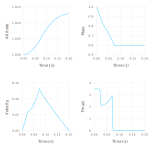

In [8]:
#using Pkg
#Pkg.add("Gadfly")
using Gadfly

# print(view(JuMP.value.(h), 1:20))

#h_plot = Gadfly.plot(x=[JuMP.value(Δt)*i for i in 1:n],y=view(JuMP.value.(h), 1:n), Geom.line,
       #         Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))

h_plot = Gadfly.plot(x=[JuMP.value(Δt)*i for i in 1:n],y=view(JuMP.value.(h), 1:n), Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = Gadfly.plot(x=[JuMP.value(Δt)*i for i in 1:n],y=view(JuMP.value.(m), 1:n), Geom.line,
               Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = Gadfly.plot(x=[JuMP.value(Δt)*i for i in 1:n],y=view(JuMP.value.(v), 1:n), Geom.line,
               Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = Gadfly.plot(x=[JuMP.value(Δt)*i for i in 1:n],y=view(JuMP.value.(T), 1:n), Geom.line,
               Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))


#m_plot = Gadfly.plot(x=(0:n)*JuMP.value(Δt),y=JuMP.value.(m), Geom.line,
#                 Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
# v_plot = Gadfly.plot(x=(0:n)*JuMP.value(Δt),y=JuMP.value.(v), Geom.line,
#                 Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
# T_plot = Gadfly.plot(x=(0:n)*JuMP.value(Δt),y=JuMP.value.(T), Geom.line,
#                 Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
# draw(SVG(6inch, 6inch), vstack( hstack(h_plot,m_plot),
#                                 hstack(v_plot,T_plot)))
Gadfly.draw(SVG(6inch, 6inch), vstack( hstack(h_plot,m_plot),
                                hstack(v_plot,T_plot)))